# Week 3 Notebook

In [1]:
# import packages
import pandas as pd
import numpy as np

# set working directory
import os
os.chdir('/home/jovyan/work/')

In [78]:
from src.data.load_dataset import load_split_store
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

# load_split_store
X_train, y_train, X_val, y_val, X_test, y_test, test_data = load_split_store(
                                                                    filepath='data/', 
                                                                    scaler=scaler, 
                                                                    resample=False, 
                                                                    random_state=42, 
                                                                    test_size=0.1, 
                                                                    replace_negatives=False)

### Baseline Model from Week 2 (submission score 0.70696)

In [4]:
import joblib

week2_model = joblib.load(open('models/david_0214_xgb_hyperopt.joblib', 'rb'))

-----------
Confusion Matrix with thresthold of 0.5:


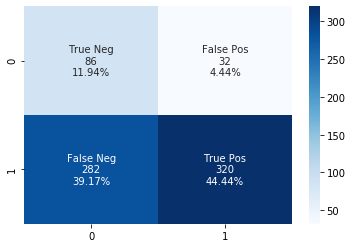

352 out of 720 or 49% of players are predicted to be 5+ Yrs
-----------
Recall: 0.5316
Accuracy: 0.5639
F1: 0.6709
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.699


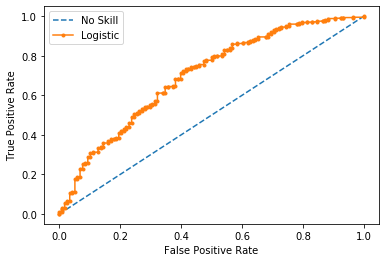

In [5]:
from src.visualization.visualize import eval_metrics

y_val_pred = week2_model.predict_proba(X_val)[:, 1]
eval_metrics(y_val_pred, y_val, praba_threshold=0.5)

## Hypothesis 1: Add Defence and Offence features (submission score: 0.70862)

#### Create new features

In [6]:
off_feat = ['PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'AST']
def_feat = ['DREB', 'STL', 'BLK']

In [7]:
from src.features.build_features import add_off_def_features

X_train_nf = add_off_def_features(off_feat, def_feat, X_train)
X_val_nf = add_off_def_features(off_feat, def_feat, X_val)
X_test_nf = add_off_def_features(off_feat, def_feat, X_test)
test_data_nf = add_off_def_features(off_feat, def_feat, test_data)

from src.features.build_features import add_features_min_average
X_train_nf = add_features_min_average(X_train_nf)
X_val_nf = add_features_min_average(X_val_nf)
X_test_nf = add_features_min_average(X_test_nf)
test_data_nf = add_features_min_average(test_data_nf)

#### Train and evaluate new base XGB model with new features

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:52:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------
Confusion Matrix with thresthold of 0.5:


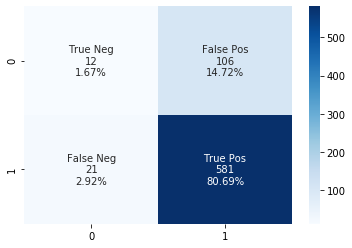

687 out of 720 or 95% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9651
Accuracy: 0.8236
F1: 0.9015
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.623


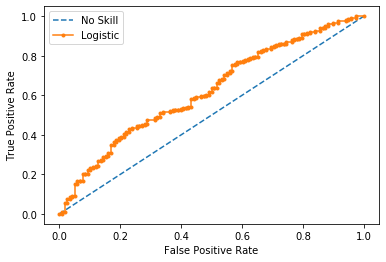

In [8]:
import xgboost as xgb
from src.visualization.visualize import eval_metrics

nf_base_model = xgb.XGBClassifier().fit(X_train_nf, y_train)
y_pred = nf_base_model.predict_proba(X_val_nf)[:,1]
eval_metrics(y_pred, y_val, praba_threshold=0.5)

#### Hyper parameter tuning with Hyperopt

In [9]:
from hpsklearn import HyperoptEstimator, sgd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

space = {
    'max_depth' : hp.choice('max_depth', range(2, 20, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.3, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 5, 30, 1),
    'subsample' : hp.quniform('subsample', 0.25, 0.4, 0.05)
}

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [10]:
def objective(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = xgb.XGBClassifier(
        objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=0.2,
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample']
    )
    
    auc = cross_val_score(xgboost, X_train_nf, y_train, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-auc, 'status': STATUS_OK }

In [11]:
best = fmin(
    fn=objective,
    space=space,       
    algo=tpe.suggest,       
    max_evals=30
)

100%|██████████| 30/30 [01:38<00:00,  3.27s/trial, best loss: 0.3002962363560814] 


-----------
Confusion Matrix with thresthold of 0.5:


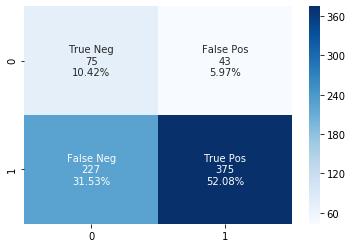

418 out of 720 or 58% of players are predicted to be 5+ Yrs
-----------
Recall: 0.6229
Accuracy: 0.625
F1: 0.7353
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.692


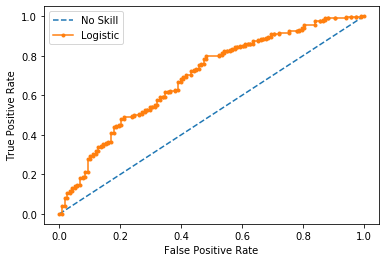

In [12]:
xgb_hpr = xgb.XGBClassifier(
    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
    scale_pos_weight=0.2,
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample']
).fit(X_train_nf, y_train)

y_pred = xgb_hpr.predict_proba(X_val_nf)[:,1]
eval_metrics(y_pred, y_val, praba_threshold=0.5)

In [13]:
from src.models.predict_model import model_submission

# this model obtain score 0.70862 (improved by 0.00166)
model_submission(xgb_hpr, test_data, modelname='david_0221_xgb_nf', submissionname='0221_xgb_nf')

#### Interpret new model with feature entropy importance 

In [14]:
import operator
feat_imp = xgb_hpr.get_booster().get_score(importance_type="gain")
feat_imp_sorted = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
feat_imp_sorted

[('GP', 16.777561813333335),
 ('FTA', 7.3000332726086965),
 ('OREB', 7.211172090937501),
 ('MIN', 5.913373924210528),
 ('FG%', 5.695739955172415),
 ('BLK', 5.170186784),
 ('defensive_ratings', 5.143258404583333),
 ('FTM', 4.8766912399999995),
 ('PTS', 4.2732028479999995),
 ('TOV', 4.1303941944444444),
 ('STL', 3.86204082),
 ('offensive_ratings', 3.7504709209090907),
 ('FTM_pm', 3.6905126936666663),
 ('REB_pm', 3.6031326858800004),
 ('AST', 3.5827195646666676),
 ('FT%', 3.580686863888889),
 ('TOV_pm', 3.579101470645161),
 ('FGA', 3.531490394285714),
 ('REB', 3.4973307484615384),
 ('3P Made', 3.427286346666667),
 ('3P%', 3.405849204125),
 ('PTS_pm', 3.36605742921875),
 ('STL_pm', 3.3629132411999993),
 ('FGM', 3.3001053685714283),
 ('DREB', 3.278317251666667),
 ('AST_pm', 3.182020375),
 ('BLK_pm', 3.0293114239565218),
 ('3PA', 2.907464724285714)]

#### Interpret new model with permutation importance

In [15]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    xgb_hpr, X_train_nf, y_train,
    n_repeats=30,
    random_state=8
)

for i in r.importances_mean.argsort()[::-1]:
     print(f"{X_train_nf.columns[i]}: {r.importances_mean[i]:.5f}")

FG%: 0.01266
GP: 0.01159
defensive_ratings: 0.00417
BLK_pm: 0.00314
BLK: 0.00289
TOV: 0.00255
AST_pm: 0.00228
PTS_pm: 0.00226
OREB: 0.00222
3P%: 0.00187
FTM_pm: 0.00183
3PA: 0.00159
STL_pm: 0.00156
offensive_ratings: 0.00123
PTS: 0.00116
FT%: 0.00115
MIN: 0.00110
FTA: 0.00096
STL: 0.00062
3P Made: 0.00054
DREB: 0.00049
REB: 0.00028
FGA: 0.00023
REB_pm: 0.00003
FGM: -0.00058
FTM: -0.00083
TOV_pm: -0.00100
AST: -0.00221


## Hypothesis 2: Split players into different clusters to assess model performance in each cluster

### Clustering method 1: Manually split into 4 groups according to offensive ratings, defensive ratings

In [16]:
X_train_nf[['offensive_ratings', 'defensive_ratings']].describe()

,offensive_ratings,defensive_ratings
count,6480.000000,6480.000000
mean,-0.006472,-0.004268
std,0.628000,0.748775
min,-1.793400,-7.878403
25%,-0.455663,-0.480235
50%,-0.093394,-0.119226
75%,0.356706,0.341032
max,3.334726,9.371563


In [17]:
off_mean = X_train_nf.offensive_ratings.mean(axis=0)
def_mean = X_train_nf.defensive_ratings.mean(axis=0)

print(f'Offensive Median Rating: {round(off_mean, 4)};  Defensive Median Rating: {round(def_mean, 4)}')

Offensive Median Rating: -0.0065;  Defensive Median Rating: -0.0043


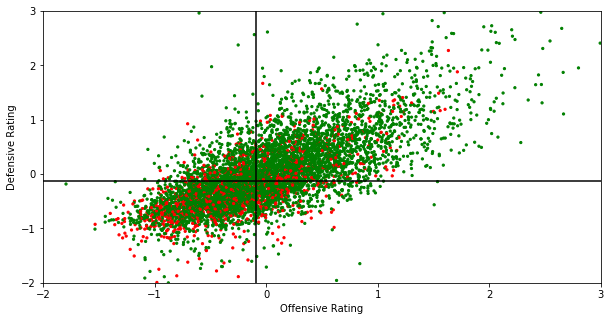

In [18]:
import matplotlib.pyplot as plt
x = X_train_nf.offensive_ratings
y = X_train_nf.defensive_ratings
colormap = np.array(['r', 'g'])

plt.figure(figsize=(10,5))
plt.scatter(x, y, c=colormap[y_train], s=5)
plt.xlim((-2,3))
plt.xlabel('Offensive Rating')
plt.ylim((-2,3))
plt.ylabel('Defensive Rating')

# plot line splitter by offensive and defensive median
plt.vlines(X_train_nf.offensive_ratings.median(axis=0), color='black', ymin=-3.0, ymax=3.0)
plt.hlines(X_train_nf.defensive_ratings.median(axis=0), color='black', xmin=-3, xmax=3)
plt.show()

In [19]:
from src.features.build_features import manual_splitter

dftrn = manual_splitter(X_train_nf, off_mean, def_mean)
dfval = manual_splitter(X_val_nf, off_mean, def_mean)
dftst = manual_splitter(X_test_nf, off_mean, def_mean)

dftrn['target'] = y_train
dfval['target'] = y_val
dftst['target'] = y_test

dfclr = dfval

df_clr = dfclr.groupby('offensive_deffensive_cluster').agg(
                                            count = ('GP', 'count'),
                                            over5yr = ('target', 'sum')
                                            )

df_clr['pct5yr'] = df_clr['over5yr'] / df_clr['count']

df_clr

,count,over5yr,pct5yr
offensive_deffensive_cluster,,,
ho_hd,267,238,0.891386
ho_ld,76,64,0.842105
lo_hd,71,60,0.845070
lo_ld,306,240,0.784314


In [20]:

pred = xgb_hpr.predict_proba(X_val_nf)[:,1]
X_val_nf.shape

(720, 28)

In [21]:
from sklearn.metrics import roc_auc_score, accuracy_score

groups = np.unique(df_clr.index)

auc_scores = []
acc_scores = []

dfval['Pred_5Yrs'] = xgb_hpr.predict_proba(X_val_nf)[:,1]

for grp in groups:
    dfg = dfval[dfval['offensive_deffensive_cluster']==grp]
    dfx = dfg.copy()    
    auc = roc_auc_score(dfx.target, dfx.Pred_5Yrs)
    auc_scores.append(auc)
    acc = accuracy_score(dfx.target, round(dfx.Pred_5Yrs, 0))
    acc_scores.append(acc)
    
df_clr['auc_score'] = auc_scores
df_clr['accuracy_score'] = acc_scores

df_clr

,count,over5yr,pct5yr,auc_score,accuracy_score
offensive_deffensive_cluster,,,,,
ho_hd,267,238,0.891386,0.630252,0.831461
ho_ld,76,64,0.842105,0.636719,0.697368
lo_hd,71,60,0.845070,0.656061,0.619718
lo_ld,306,240,0.784314,0.719508,0.428105


The above group analysis indicated that the ho_hd (high offensive high defensive) group has the lowest roc_auc score with highest accuracy score compare the the other groups. This finding suggest a potential split from ho_hd from the other 3 groups for training and/or setting different prediction threshold.  

#### Local Interpretation with LIME
False Negative: id=5928 | False Positive: id=3129

In [22]:
from lime.lime_tabular import LimeTabularExplainer

dfx = dftrn.copy()
dfx = dfx.drop(['target', 'offensive_deffensive_cluster'], axis=1)

lime_explainer = LimeTabularExplainer(dfx,
                                      feature_names=dfx.columns,
                                      class_names=['Under 5 Yr', 'Over 5 Yr'],
                                      mode='classification',
                                      discretize_continuous=False
                                    )

#### False Negative investigation 5928
Player with below average performance on most stats except 3 point shooting. Predicted to be 'Under 5 years'. I see nothing wrong with prediction.

In [23]:
train_data = pd.read_csv('data/raw/train.csv')
player_comparison = pd.DataFrame({'all_player_avg': train_data.describe().loc['mean'], 'player_5928':train_data.loc[5928]})
player_comparison['against_average'] = np.where(player_comparison['all_player_avg']>=player_comparison['player_5928'], 'below avg', 'equal or above')
player_comparison

,all_player_avg,player_5928,against_average
Id_old,6856.971000,5263.0,below avg
Id,7798.500000,9727.0,equal or above
GP,62.777875,30.0,below avg
MIN,18.576662,7.6,below avg
PTS,7.267088,2.8,below avg
FGM,2.807037,1.1,below avg
FGA,6.231212,2.9,below avg
FG%,44.608900,36.6,below avg
3P Made,0.264525,0.4,equal or above
3PA,0.816562,1.2,equal or above


In [24]:
exp = lime_explainer.explain_instance(dfx.loc[5928], 
                                      xgb_hpr.predict_proba,
                                      top_labels=1,
                                      num_features=15)

exp.show_in_notebook()

#### False Negative Investigation id 3129
Player with better than average performance on most stats. Predicted to be 'Over 5 years'. I see nothing wrong with prediction.

In [25]:
player_comparison = pd.DataFrame({'all_player_avg': train_data.describe().loc['mean'], 'player_3129':train_data.loc[3129]})
player_comparison['against_average'] = np.where(player_comparison['all_player_avg']>=player_comparison['player_3129'], 'below avg', 'equal or above')
player_comparison

,all_player_avg,player_3129,against_average
Id_old,6856.971000,6306.0,below avg
Id,7798.500000,6928.0,below avg
GP,62.777875,85.0,equal or above
MIN,18.576662,20.9,equal or above
PTS,7.267088,10.8,equal or above
FGM,2.807037,3.8,equal or above
FGA,6.231212,9.0,equal or above
FG%,44.608900,42.0,below avg
3P Made,0.264525,0.7,equal or above
3PA,0.816562,1.6,equal or above


In [26]:
exp = lime_explainer.explain_instance(dfx.loc[3129], 
                                      xgb_hpr.predict_proba,
                                      top_labels=1,
                                      num_features=15)

exp.show_in_notebook()

### Clustering Method 2: Use Guassian Mixer for auto clustering

In [104]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), timings=False)

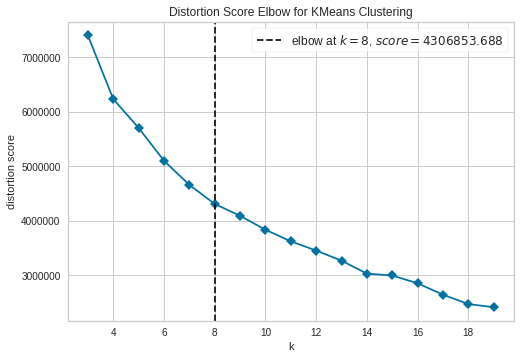

In [105]:
visualizer.fit(X_train)
visualizer.show()

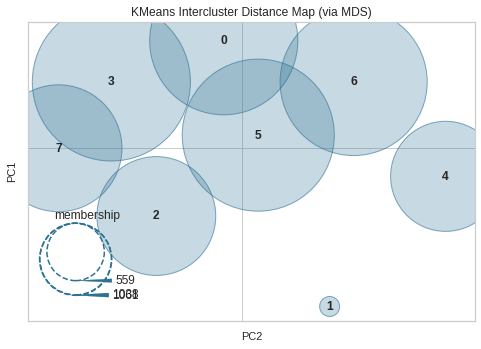

In [106]:
from yellowbrick.cluster import InterclusterDistance
model = KMeans(8)
kvisualizer = InterclusterDistance(model, random_state=0)
kvisualizer.fit(X_train)
kvisualizer.show()

In [34]:
from sklearn.mixture import GaussianMixture

nc = 8

clr_model = GaussianMixture(nc, random_state=42)
clr_model.fit(X_train)

obs = clr_model.predict(X_train)

In [35]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

y_train_pred = xgb_hpr.predict_proba(X_train)[:,1]

df_train_cluster = pd.DataFrame({'clr_group':obs, 'TARGET_5Yrs':y_train, 'Pred_5Yrs':y_train_pred})

clr_comp = df_train_cluster.groupby('clr_group').agg(
                                                    count=('TARGET_5Yrs', 'count'),
                                                    tot_5yr=('TARGET_5Yrs', 'sum')
                                                    )

clr_comp['pct_5yr'] = clr_comp['tot_5yr'] / clr_comp['count']

clr_comp

,count,tot_5yr,pct_5yr
clr_group,,,
0,1313,1179,0.897944
1,556,522,0.938849
2,339,241,0.710914
3,824,691,0.838592
4,832,726,0.872596
5,205,181,0.882927
6,902,624,0.691796
7,1509,1219,0.807820


In [36]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

clusters = np.unique(obs)
auc_scores = []
acc_scores = []

for grp in clusters:
    df = df_train_cluster[df_train_cluster['clr_group']==grp]
    try:
        auc = roc_auc_score(df.TARGET_5Yrs, df.Pred_5Yrs)
    except:
        auc = None
    auc_scores.append(auc)
    acc = accuracy_score(df.TARGET_5Yrs, round(df.Pred_5Yrs, 0))
    acc_scores.append(acc)
    
#     print(f'{grp}: AUC- {auc}, ACC- {acc}')
    
clr_comp['auc_score'] = auc_scores
clr_comp['accuracy_score'] = acc_scores

clr_comp

,count,tot_5yr,pct_5yr,auc_score,accuracy_score
clr_group,,,,,
0,1313,1179,0.897944,0.736356,0.758568
1,556,522,0.938849,0.702502,0.897482
2,339,241,0.710914,0.658015,0.368732
3,824,691,0.838592,0.611754,0.447816
4,832,726,0.872596,0.649709,0.688702
5,205,181,0.882927,0.851980,0.829268
6,902,624,0.691796,0.634033,0.363636
7,1509,1219,0.807820,0.671361,0.432074


The above group analysis indicated that the current model performs poorly for groups 2, 3, 4 and 6. This finding suggest a potential split by groups (2,3,4,6) and groups (0,1,5,7) for training and/or setting different prediction threshold.

#### Split data according to cluster groups

In [52]:
from src.features.build_features import data_splitter

X_train_p1, y_train_p1, X_train_p2, y_train_p2 = data_splitter(clr_model, X_train, y_train, off_feat, def_feat)
X_val_p1, y_val_p1, X_val_p2, y_val_p2 = data_splitter(clr_model, X_val, y_val, off_feat, def_feat)

#### Split data for training separate xgb models

#### Hypoeopt for part 1

In [39]:
def objective1(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = xgb.XGBClassifier(
        objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=0.2,
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample']
    )
    
    auc = cross_val_score(xgboost, X_train_p1, y_train_p1, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-auc, 'status': STATUS_OK }

In [46]:
best1 = fmin(
    fn=objective1,
    space=space,       
    algo=tpe.suggest,       
    max_evals=30
)

100%|██████████| 30/30 [00:42<00:00,  1.42s/trial, best loss: 0.34166583614303525]


#### Hypoeopt for part 2

In [47]:
def objective2(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = xgb.XGBClassifier(
        objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=0.2,
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample']
    )
    
    auc = cross_val_score(xgboost, X_train_p2, y_train_p2, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-auc, 'status': STATUS_OK }

In [48]:
best2 = fmin(
    fn=objective2,
    space=space,       
    algo=tpe.suggest,       
    max_evals=30
)

100%|██████████| 30/30 [00:50<00:00,  1.68s/trial, best loss: 0.298342040477637]  


#### Train models

In [49]:
xgb_hpr_p1 = xgb.XGBClassifier(
    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', scale_pos_weight=0.2,
    max_depth = best1['max_depth'],
    learning_rate = best1['learning_rate'],
    min_child_weight = best1['min_child_weight'],
    subsample = best1['subsample']
).fit(X_train_p1, y_train_p1)

In [50]:
xgb_hpr_p2 = xgb.XGBClassifier(
    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', scale_pos_weight=0.2,
    max_depth = best2['max_depth'],
    learning_rate = best2['learning_rate'],
    min_child_weight = best2['min_child_weight'],
    subsample = best2['subsample']
).fit(X_train_p2, y_train_p2)

In [58]:
y1 = xgb_hpr_p1.predict_proba(X_val_p1)[:,1]
y2 = xgb_hpr_p2.predict_proba(X_val_p2)[:,1]

In [59]:
y_val_pred = np.append(y1, y2)
y_val_actual = np.append(y_val_p1, y_val_p2)

-----------
Confusion Matrix with thresthold of 0.5:


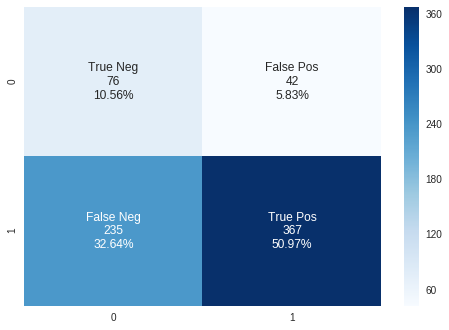

409 out of 720 or 57% of players are predicted to be 5+ Yrs
-----------
Recall: 0.6096
Accuracy: 0.6153
F1: 0.726
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.691


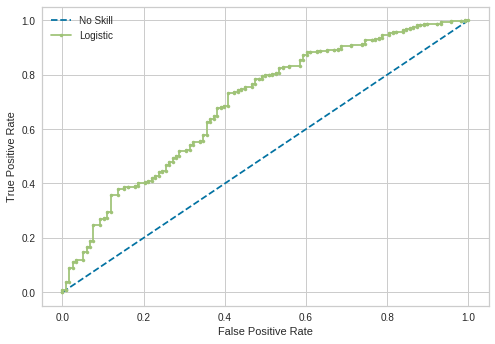

In [60]:
eval_metrics(y_val_pred, y_val_actual, praba_threshold=0.5)

#### Evaluate performance by cluster of the new model

In [64]:
df_val_cluster = X_val_p1.append(X_val_p2)
df_val_cluster['target'] = y_val_actual
df_val_cluster['pred'] = y_val_pred

In [66]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

clr_comp = df_val_cluster.groupby('cluster').agg(
                                                    count=('target', 'count'),
                                                    tot_5yr=('target', 'sum')
                                                    )

clr_comp['pct_5yr'] = clr_comp['tot_5yr'] / clr_comp['count']

clusters = np.unique(obs)

auc_scores = []
acc_scores = []

for grp in clusters:
    df = df_val_cluster[df_val_cluster['cluster']==grp]
    try:
        auc = roc_auc_score(df.target, df.pred)
    except:
        auc = None
    auc_scores.append(auc)
    acc = accuracy_score(df.target, round(df.pred, 0))
    acc_scores.append(acc)
    
clr_comp['auc_score'] = auc_scores
clr_comp['accuracy_score'] = acc_scores

clr_comp

,count,tot_5yr,pct_5yr,auc_score,accuracy_score
cluster,,,,,
0,145,130,0.896552,0.583590,0.806897
1,80,73,0.912500,0.724070,0.900000
2,30,18,0.600000,0.689815,0.366667
3,77,62,0.805195,0.640860,0.545455
4,106,91,0.858491,0.730403,0.735849
5,22,18,0.818182,0.791667,0.863636
6,90,63,0.700000,0.666079,0.344444
7,170,147,0.864706,0.612836,0.429412


It is noted that the group 0 and 7 performance dropped considerably compare to the previous model

#### Predict test data 

In [101]:
test_data_raw = pd.read_csv('data/raw/test.csv')

test_data_raw.pop('Id_old')
test_id = test_data_raw.pop('Id')

In [102]:
obs = clr_model.predict(test_data_raw)

# combine data for later split
data_split = test_data_raw.copy()
data_split['Id'] = test_id
data_split['cluster'] = obs

# add offensive and defensive ratings
data_split = add_off_def_features(off_feat, def_feat, data_split)

# add per minute features
data_split = add_features_min_average(data_split)

# split data by cluster groups
p1_clr = [2,3,4,6]
p2_clr = [0,1,5,7]

# split data
test_data_p1 = data_split[data_split['cluster'].isin(p1_clr)]
test_data_p2 = data_split[data_split['cluster'].isin(p2_clr)]

In [103]:
test_data_p1.pop('cluster')
test_data_p2.pop('cluster')
test_id1 = test_data_p1.pop('Id')
test_id2 = test_data_p2.pop('Id')
y1 = xgb_hpr_p1.predict_proba(test_data_p1)[:,1]
y2 = xgb_hpr_p2.predict_proba(test_data_p2)[:,1]

test_data_p1['Id'] = test_id1
test_data_p2['Id'] = test_id2
test_data_p1['TARGET_5Yrs'] = y1
test_data_p2['TARGET_5Yrs'] = y2

test_X = test_data_p1.append(test_data_p2)
test_X = test_X.sort_values(by=['Id'])
submission = test_X[['Id', 'TARGET_5Yrs']]
submission.to_csv('data/submission/0221_xgb_cluster.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.